In [31]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
import theano.tensor as T
from theano.compile.ops import as_op
import theano

## Manufacturing Uncertainty with Bayesian Networks 
### From S. Nannapaneni et al. 2016

![weld](./weld.PNG)

The Volume of a weld is given as 
$$V = L\left(\frac{3}{4}lh+gt+\frac{l-g}{2}(t-e)\right)$$
Where V and L represent the volume of the weld and the length of the weld respectively. Assuming the filler and metal are the same material, we model the theoretical enery required for the weld process to be given as 

$$E_{AP}^{TR} = \rho(C_p(T_f-T_i)+H)V $$

where $E$, $\rho$, $C_p$, $T_f$, $T_i$, $H$ represent the theoretical minimum energy, density of the material, heat capacity, final and initial temperatures, and latent heat of the material

This can be codified as a Bayes Net. We assume that the dimensioning parameters $l$, $h$, $e$ are random variables, each with unknown distribution parameters $\mu$, $\sigma$ (assuming they are Normally distributed). 

![net](./weldBN.PNG)
In addition, we have observed values for $l$, $h$, $e$, allowing us to update the posterior distribution using MCMC (Or, in the case of PyMC3, the No-U-Turn Sampler a.k.a. NUTS)

### Sampling the prior distribution
To get an approximation for our current belief in the distribution for minimum energy usage, we will perform sampling without any observations:

In [32]:
n_samp = 10000

with pm.Model() as model_prior:
# Weld Parameters (all in mm)
    #length "l"
    mu_l = pm.Uniform('mu_l', lower=8.2*1e-3, upper=8.6*1e-3)
    sd_l = pm.Uniform('sd_l', lower=0.2*1e-3, upper=0.7*1e-3)
    l = pm.Normal('l', mu=mu_l, sd=sd_l)
    
    #height "h"
    mu_h = pm.Uniform('mu_h', 2.5*1e-3, 2.8*1e-3)
    sd_h = pm.Uniform('sd_h', 0.3*1e-3, 0.6*1e-3)
    h = pm.Normal('h', mu_h, sd=sd_h)
    
    #escape "e"  # ???
    mu_e = pm.Uniform('mu_e', 10.*1e-3, 13.*1e-3)
    sd_e = pm.Uniform('sd_e', 0.8*1e-3, 1.3*1e-3)
    e = pm.Normal('e', mu_e, sd=sd_e)
    
    len_w = pm.Normal('L', 500.*1e-3, 10.*1e-3)  # Length of Weld "L"
    g = pm.Normal('g', 2.*1e-3, sd=0.1*1e-3)  # girth "g" ?
    t = pm.Normal('t', 15.*1e-3, sd=0.5*1e-3)  # plate thickness "t"
    
#     v_err = pm.HalfCauchy('sd_V', 1.) # makes more sense as conjugate?
#     v_mu = T.mean(len_w*((3./4.)*l*h + g*t + (l-g)*(t-e)/2.))
#     vol = pm.Normal('V', v_mu, v_err) #treating as non-deterministic
    vol = pm.Deterministic('V', # Volume, mm^3
                       len_w*((3./4.)*mu_l*mu_h + g*t + (mu_l-g)*(t-mu_e)/2.) )
    
# Welding Process
    rho = pm.Normal('Density', 8238., sd=10.)  # kg/m^3
    heat = pm.Normal('H', 270*1e3, sd=3*1e3)  # latent heat 
    h_cap = pm.Normal('C_p', 500., sd=5.)  # heat capacity
    t_i = pm.Normal('T_i', 303., sd=0.3)  # initial temp
    t_f = pm.Normal('T_f', 1628., sd=10.)  # final temp
    
#     nrg_err = pm.HalfCauchy('sd_E', 1.)
#     nrg_mu = T.mean(rho*(h_cap*(t_f-t_i) + heat)*vol)
#     nrg = pm.Normal('Energy', nrg_mu, nrg_err)
    nrg = pm.Deterministic('Energy', rho*(h_cap*(t_f-t_i) + heat)*vol)

with model_prior:
    step = pm.Metropolis()
    trace_prior = pm.sample(n_samp, step=step)

100%|███████████████████████████████████| 10000/10000 [00:12<00:00, 801.15it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003A762518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000019DB8320>]], dtype=object)

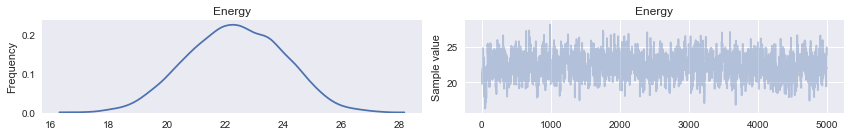

In [33]:
pm.traceplot(trace_prior[n_samp/2:], varnames=['Energy'], transform=lambda x:x*1e-4)

Note the `T.mean()` call in the Energy node. As this is a deterministic, Theano will treat each "observation" in the next implementation as a separate deterministic case, leading to a sampling of as many "energy distributions" as we have unique observations (in this case, 100, as we see below). This is undesireable, wo we take a mean of all calculated energies as the deterministic input. A more "bayes" way to do this might be to have the function be the location parameter for a random "energy" variable and place a prior on the scale parameter, but this is not how the paper authors proceed. 

### Sampling the posterior:

To mimic the original, we will generate a toy dataset for the observed variables $l$, $h$, $e$ using a Normal distribution for each: 

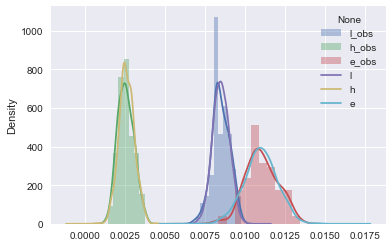

In [34]:
from scipy.stats import norm

# Synthetic Data-set (observations)
np.random.seed(19806) #random.org

num_obs = 100
l_obs = norm(8.5*1e-3, 0.5*1e-3).rvs(size=100)
h_obs = norm(2.6*1e-3, 0.5*1e-3).rvs(size=100)
e_obs = norm(11.*1e-3, 1.*1e-3).rvs(size=100)



for i in [l_obs, h_obs, e_obs]:
    sns.distplot(i) 
plt.legend([
    'l_obs',
    'h_obs',
    'e_obs'
])

# functionally the same
synth = np.loadtxt('Weld_UQ_data.txt', skiprows=0, usecols=(0,1,2))
synth=pd.DataFrame(data=synth, columns=['l','h','e'])
synth.plot.kde(ax=plt.gca())

# synth['h'].values.reshape((-1,1))

Now add the observations at the nodes and sample the new model:

In [35]:

with pm.Model() as model:

# Weld Parameters
    #length "l"
    mu_l = pm.Uniform('mu_l', lower=8.3*1e-3, upper=8.6*1e-3)
    sd_l = pm.Uniform('sd_l', lower=0.2*1e-3, upper=0.7*1e-3)
    l = pm.Normal('l', mu=mu_l, sd=sd_l, observed=synth['l'])
    
    #height "h"
    mu_h = pm.Uniform('mu_h', 2.5*1e-3, 2.8*1e-3)
    sd_h = pm.Uniform('sd_h', 0.3*1e-3, 0.6*1e-3)
    h = pm.Normal('h', mu_h, sd=sd_h, observed=synth['h'])
    
    #escape "e"  # ???
    mu_e = pm.Uniform('mu_e', 10.*1e-3, 13.*1e-3)
    sd_e = pm.Uniform('sd_e', 0.8*1e-3, 1.3*1e-3)
    e = pm.Normal('e', mu_e, sd=sd_e, observed=synth['e'])
    
    len_w = pm.Normal('L', 500.*1e-3, sd=10.*1e-3)  # Length of Weld "L"
    g = pm.Normal('g', 2.*1e-3, sd=0.1*1e-3)  # girth "g" ?
    t = pm.Normal('t', 15.*1e-3, sd=0.5*1e-3)  # plate thickness "t"

    vol = pm.Deterministic('V', # Volume, mm^3
                       len_w*((3./4.)*mu_l*mu_h + g*t + (mu_l-g)*(t-mu_e)/2.)) 
    #no mult. by len_w ? 

# Welding Process
    rho = pm.Normal('Density', 8238., sd=10.)  # kg/m^3
    heat = pm.Normal('H', 270*1e3, sd=3*1e3)  # latent heat 
    h_cap = pm.Normal('C_p', 500., sd=5.)  # heat capacity
    t_i = pm.Normal('T_i', 303., sd=0.3)  # initial temp
    t_f = pm.Normal('T_f', 1628., sd=10.)  # final temp
    
#     eps = pm.HalfCauchy('eps', 5)
    nrg = pm.Deterministic('Energy', var=rho*(h_cap*(t_f-t_i) + heat)*vol)
#     nrg = pm.Normal('Energy', mu=T.mean(rho*(h_cap*(t_f-t_i) + heat)*vol), sd=eps)

In [36]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(n_samp, step=step)

100%|███████████████████████████████████| 10000/10000 [00:11<00:00, 865.20it/s]


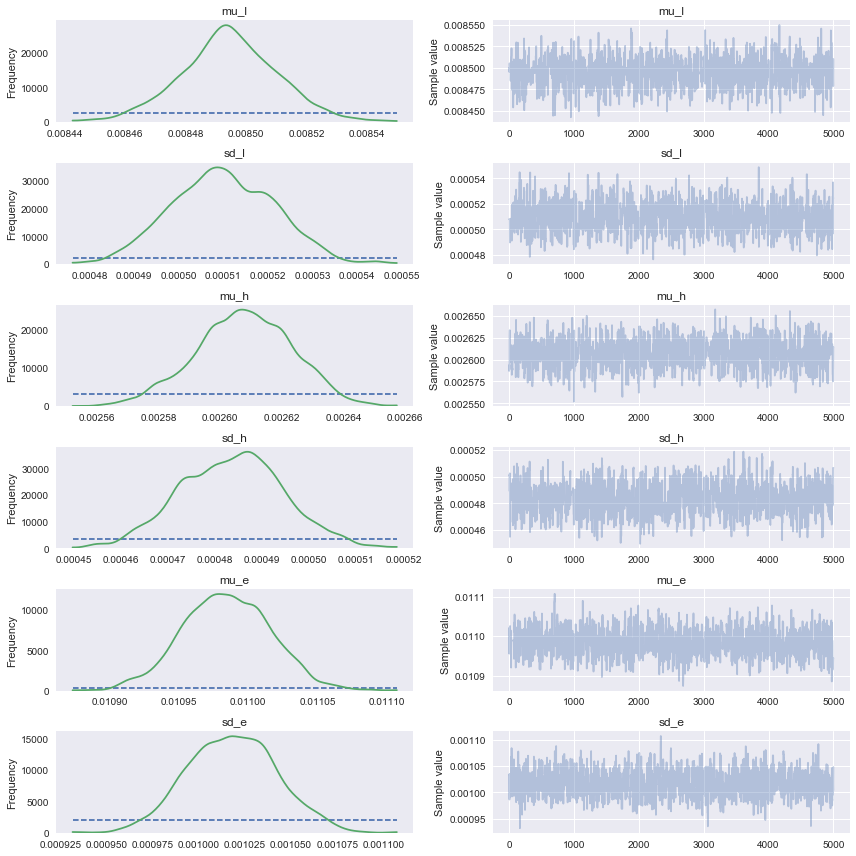

In [37]:
ax = pm.traceplot(trace[n_samp/2:], varnames=['mu_l', 'sd_l',
                              'mu_h', 'sd_h',
                              'mu_e', 'sd_e'], 
             priors=[pm.Uniform.dist(8.2*1e-3, 8.6*1e-3),
                     pm.Uniform.dist(0.2*1e-3, 0.7*1e-3),
                     pm.Uniform.dist(2.5*1e-3, 2.8*1e-3),
                     pm.Uniform.dist(0.3*1e-3, 0.6*1e-3),
                     pm.Uniform.dist(10*1e-3, 13.*1e-3),
                     pm.Uniform.dist(0.8*1e-3, 1.3*1e-3)])



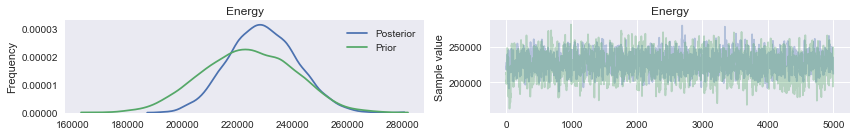

In [38]:
# pm.sample_ppc()
ax = pm.traceplot(trace[n_samp/2:], varnames=['Energy'])
pm.traceplot(trace_prior[n_samp/2:], varnames=['Energy'], ax=ax)

ax[0][0].legend(['Posterior', 'Prior'])

### Comparison with Paper

We will show the prior and posterior distributions for the location/shape parameters of $l$, $h$, $e$, along with the "Energy" variable.  

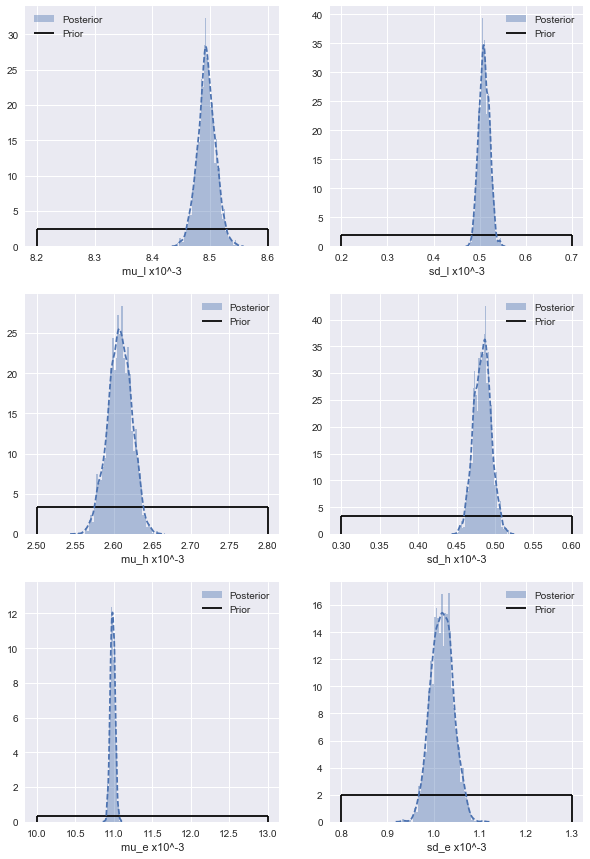

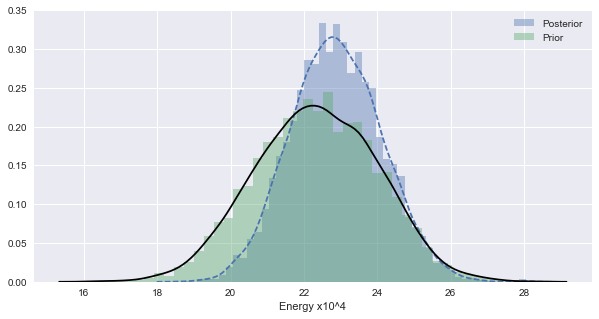

In [39]:
lims = [(8.2*1e-3, 8.6*1e-3),
        (0.2*1e-3, 0.7*1e-3),
        (2.5*1e-3, 2.8*1e-3),
        (0.3*1e-3, 0.6*1e-3),
        (10.*1e-3, 13.*1e-3),
        (0.8*1e-3, 1.3*1e-3)]
varnames=['mu_l', 'sd_l',
          'mu_h', 'sd_h',
          'mu_e', 'sd_e']

def compare_dist(ax, dat, lim, scale=1.):
    sns.distplot(scale*dat, ax=ax, kde=True, label='Posterior', kde_kws={'ls':'--'})
    a,b = scale*lim[0], scale*lim[1]
    y = 1./(b-a)
    ax.hlines(y=y, xmin=a, xmax=b, linestyles=u'solid', label='Prior')
    ax.vlines([a,b],ymin=0, ymax=y, linestyles=u'solid')
    ax.legend()

f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

for n, ax in enumerate(axes.flat):
    compare_dist(ax, trace[n_samp/2:].get_values(varnames[n]), lims[n], scale=1e3)
    ax.set_xlabel("{} x10^{}".format(varnames[n], -3))


f2 = plt.figure(figsize=(10,5))
sns.distplot(trace[n_samp/2:].get_values('Energy')*1e-4, kde=True, label='Posterior', kde_kws={'ls':'--'})
sns.distplot(trace_prior[n_samp/2:].get_values('Energy')*1e-4, label='Prior', kde_kws={'color':'k'})
plt.legend()
plt.xlabel('Energy x10^{}'.format(4))

Compare to the original results: 

![paper](./paper.PNG)

## Injection Molding Example


In [132]:
COP = 0.7  # coefficient of performance
nu = 0.7  # Energy Coef.
n = 1.  # number of cavities
delta = 0.015  # fraction
h_max = 0.0125  # max thickness
v_part = 0.002048  # part volume

# polyethylene material constants
# .... why is this unused?
y = 2.27*1e-7  # thermal Diffusivity
h_f = 240.  # Heat of Fusion

# not defined and set to 1 despite aleatory claim in paper:
P_basic = 1.
t_cycle = 1.
t_pol = 1.

with pm.Model() as inject_prior:
# Material Properties of Polyelthylene polymer (under uncertainty)
    rho = pm.Uniform('Density', 950., 990.)
    c_p = pm.Uniform('Heat Capacity', 2250., 2262.)
    eps = pm.Uniform('Shrinkage', 0.018, 0.021)
    
# Calibration Parameters for injection molding process
    t_ij = pm.Uniform('Inj Temp.', 205., 220.)
    t_ej = pm.Uniform('Ej. Temp.', 45., 60.)
    t_md = pm.Uniform('Mold Temp.', 30., 45.)  # Why is this unused? 
    p_ij = pm.Uniform('Inj. Press.', 88., 95.)
    q = pm.Uniform('Flow Rate', 1.6*1e-5, 1.75*1e-5)
    
# melting process
    p_melt = rho*0.5*q*(t_ij-t_pol) + rho*0.5*q*h_f  # melting pressure
    v_shot = v_part*(1. + eps/100. + delta/100.)  # volume accounting for shrinkage
    E_melt = p_melt*v_shot/q  # energy for melting
    # t_pol (init. polymer temp) is not defined...
    
# injection into mold
    E_ij =  p_ij*v_part  # energy for injection
    
# cooling of polymer
    E_cool = rho*v_part*(c_p*(t_ij-t_ej))/COP  # energy for cooling
    
# resetting the process
    E_reset = 0.25*(E_ij + E_cool + E_melt)

# Total part energy
    E_part = pm.Deterministic('Part Energy', 
                              (1./n)*(((0.75*E_melt+E_ij)/nu +\
                                       E_reset/nu +\
                                       E_cool/nu +\
                                       0.25*E_melt/nu)*\
                                      n*(1+eps+delta)/nu +P_basic*t_cycle)
                             )  
    # P_basic (i.e. power) is not defined...
    # t_cycle (time) is not defined...
    
    
    
    
    

![inj_bn](./injBN.PNG)

In [135]:
with inject_prior:
#     start = pm.find_MAP()
    step = pm.Metropolis()
    chain_prior = pm.sample(10000, start=start, step=step, 
                           trace=[t_ij,t_ej,t_md,p_ij,q,E_part])

100%|██████████████████████████████████| 10000/10000 [00:05<00:00, 1883.95it/s]


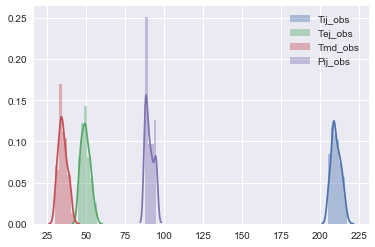

In [169]:
from scipy.stats import norm

# Synthetic Data-set (observations)
np.random.seed(19806) #random.org

num = 100
Tij_obs = np.clip(norm(210., 3.).rvs(size=num), 205., 220.) 
Tej_obs = np.clip(norm(50., 3.).rvs(size=num), 45., 60.)  # Error in Paper!
Tmd_obs = np.clip(norm(35., 3.).rvs(size=num), 30., 45.)  # Error in Paper!
Pij_obs = np.clip(norm(90., 4.).rvs(size=num), 88., 95.)

for i in [Tij_obs, Tej_obs, Tmd_obs, Pij_obs]:
    sns.distplot(i) 
plt.legend([
    'Tij_obs',
    'Tej_obs',
    'Tmd_obs',
    'Pij_obs'
])

In [170]:
COP = 0.7  # coefficient of performance
nu = 0.7  # Energy Coef.
n = 1.  # number of cavities
delta = 0.015  # fraction
h_max = 0.0125  # max thickness
v_part = 0.002048  # part volume

# polyethylene material constants
# .... why is this unused?
y = 2.27*1e-7  # thermal Diffusivity
h_f = 240.  # Heat of Fusion

# not defined and set to 1 despite aleatory claim in paper:
P_basic = 1.
t_cycle = 1.
t_pol = 1.

with pm.Model() as inject:
# Material Properties of Polyelthylene polymer (under uncertainty)
    rho = pm.Uniform('Density', 950., 990.)
    c_p = pm.Uniform('Heat Capacity', 2250., 2262.)
    eps = pm.Uniform('Shrinkage', 0.018, 0.021)
    
# Calibration Parameters for injection molding process
    t_ij = pm.Uniform('Inj. Temp.', 205., 220.)
    # add measurement w/error node
    t_ij_o = pm.Normal('Inj. Temp. Obsv.',t_ij, sd=3., observed=Tij_obs)
    
    t_ej = pm.Uniform('Ej. Temp.', 45., 60.)
    # add measurement w/error node
    t_ej_o = pm.Normal('Ej. Temp. Obsv.',t_ej, sd=3., observed=Tej_obs)
    
#     t_md = pm.Uniform('Mold Temp.', 30., 45., observed=Tmd_obs)  # Why is this unused? 
#     t_ij_o = pm.Normal('Inj. Temp. Obsv.',t_ij, sd=3., observed=Tij_obs)
    p_ij = pm.Uniform('Inj. Press.', 88., 95.)
    # add measurement w/error node
    p_ij_o = pm.Normal('Inj. Press. Obsv.',p_ij, sd=4., observed=Pij_obs)
    
    q = pm.Uniform('Flow Rate', 1.6*1e-5, 1.75*1e-5)
    
# melting process
    p_melt = pm.Deterministic('Melt Press.', 
                              T.mean(rho*0.5*q*(t_ij-t_pol) + rho*0.5*q*h_f))
    v_shot = pm.Deterministic('Shot Vol.',  # accounting for shrinkage
                              v_part*(1. + eps/100. + delta/100.))
    E_melt = pm.Deterministic('Melt Energy', p_melt*v_shot/q)
    # t_pol (init. polymer temp) is not defined...
    
# injection into mold
    E_ij =  pm.Deterministic('Inj. Energy', T.mean(p_ij*v_part))
    
# cooling of polymer
    E_cool = pm.Deterministic('Cooling Energy', T.mean(rho*v_part*(c_p*(t_ij-t_ej))/COP)) 
    
# resetting the process
    E_reset = pm.Deterministic('Reset Energy', 0.25*(E_ij + E_cool + E_melt))

# Total part energy
    E_part = pm.Deterministic('Part Energy', T.mean(
                              (1./n)*(((0.75*E_melt+E_ij)/nu +\
                                       E_reset/nu +\
                                       E_cool/nu +\
                                       0.25*E_melt/nu)*\
                                      n*(1+eps+delta)/nu +P_basic*t_cycle))
                             )  
    # P_basic (i.e. power) is not defined...
    # t_cycle (time) is not defined...
    
    

In [171]:
with inject:
#     start = pm.find_MAP()
    step=pm.Metropolis()
    chain = pm.sample(10000, step=step,
                      trace=[t_ij,t_ej,p_ij,q,E_part])

100%|██████████████████████████████████| 10000/10000 [00:05<00:00, 1693.48it/s]


An important thing to note here is that PyMC3 does not treat "observed" variables as stochastics ...i.e. every observation seems to be generating a separate "sampling thread". This means there is no "posterior" of the nodes *where observations are*, since those are what we see as "truth". 

So to get around the static nature of observed nodes, I've made the observations occur in a gaussian node inheriting the original priors as a mean. The paper states "measurement errors in temperature and pressure are assumed to have normal distributions with zero means and standard devieations of 3C and 4 MPa, respectively." We treat this as a measurement node in the network, with a mean observed from the process node (the uniform prior) and a SD of 3 or 4. This is where the observations are used, so that the posterior of the process nodes are defined (they aren't static) to match the paper analysis.

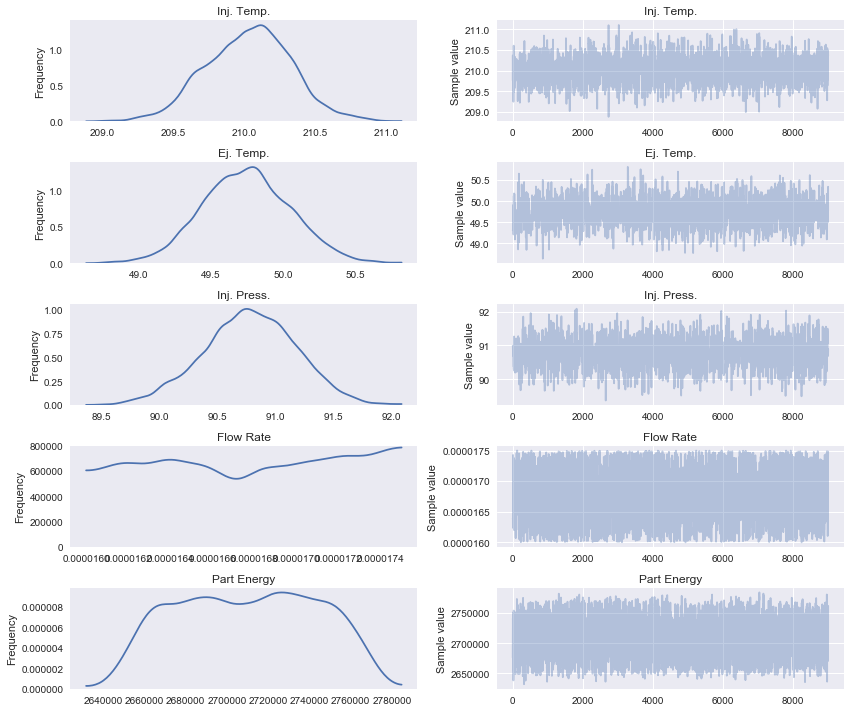

In [172]:
ax = pm.traceplot(chain[1000:])  # burnin of 1000 samples

### Comparison with paper

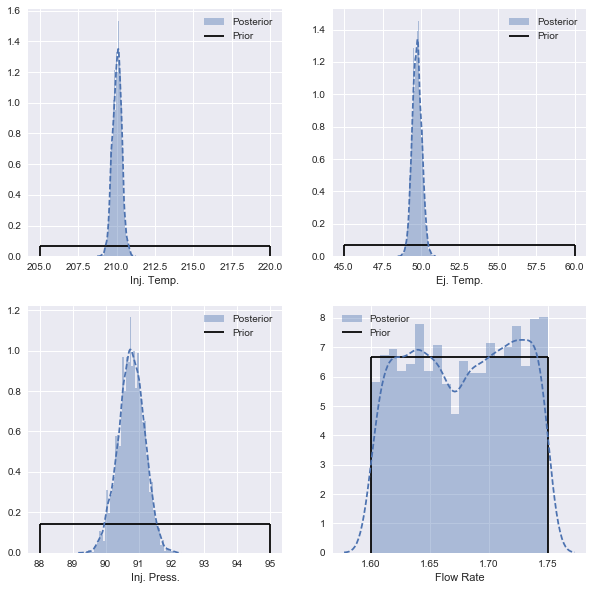

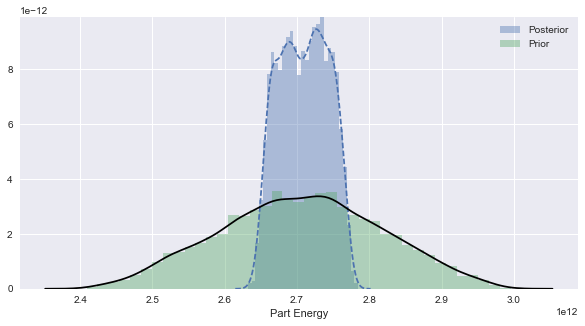

In [218]:
lims = [(205., 220.), 
        (45., 60.), 
        (88., 95.), 
        (1.6, 1.75)]
varnames=['Inj. Temp.',
          'Ej. Temp.',
          'Inj. Press.',
          'Flow Rate']
# Mold Temp left out as unecessary (unused in tree)

def compare_dist(ax, dat, lim):
    sns.distplot(dat, ax=ax, kde=True, label='Posterior', kde_kws={'ls':'--'})
    a,b = lim
    y = 1./(b-a)
    ax.hlines(y=y, xmin=a, xmax=b, linestyles=u'solid', label='Prior')
    ax.vlines([a,b],ymin=0, ymax=y, linestyles=u'solid')
    ax.legend()

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for n, ax in enumerate(axes.flat[:3]):
    compare_dist(ax, chain[1000:].get_values(varnames[n]), lims[n])
    ax.set_xlabel(varnames[n])
    
compare_dist(axes[1][1], chain[1000:].get_values(varnames[-1])*1e5, lims[-1])
axes[1][1].set_xlabel(varnames[-1])


f2 = plt.figure(figsize=(10,5))
sns.distplot(chain[1000:].get_values('Part Energy')*1e6, kde=True, label='Posterior', kde_kws={'ls':'--'})
sns.distplot(chain_prior[1000:].get_values('Part Energy')*1e6, label='Prior', kde_kws={'color':'k'})
plt.legend()
plt.xlabel('Part Energy')

![inj_Paper](./injPaper.PNG)